# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump

pd.options.display.max_columns = 999

%matplotlib inline

# Import data

In [2]:
df19 = pd.read_excel('../datasets/2019 FE Guide-release dates before 9-24-2019-no-sales- 9_23_2019public 2.xlsx')
df14 = pd.read_excel('../datasets/2014 FEGuide for DOE-OK to release-no-sales-5-8-2019_updated_VWGas_public.xlsx')
df15 = pd.read_excel('../datasets/2015 FEGuide for DOE-OK to release-no-sales-5-8-2019_updated_VWGas_public.xlsx')
df16 = pd.read_excel('../datasets/2016 FEGuide for DOE-OK to release-no-sales-5-8-2019_updated_VWGas_public.xlsx')
df17 = pd.read_excel('../datasets/2017 FE Guide for DOE-release dates before 3-25-2019-no sales-9-19-2019VWGas_public.xlsx')
df18 = pd.read_excel('../datasets/2018 FE Guide for DOE3 -all rel dates-no-sales-3-25-2019Maseratiforpublic.xlsx')

# # Check if all columns for every dataset are the same
print((list(df19.columns.values) == list(df14.columns.values)) and
      (list(df19.columns.values) == list(df15.columns.values)) and
      (list(df19.columns.values) == list(df16.columns.values)) and 
      (list(df19.columns.values) == list(df17.columns.values)) and 
      (list(df19.columns.values) == list(df18.columns.values)))

True


In [3]:
# Combine dfs into one
df = pd.concat([df14, df15, df16, df17, df18])
df_test = df19

In [4]:
# since we combined 5 CSVs together, need to reset indexes
print(df.shape)
print(df_test.shape)
print(df['Verify Mfr Cd'][0])

df = df.reset_index(drop=True)
print("after reset: ")
print(df['Verify Mfr Cd'][0])

(6197, 162)
(1260, 162)
0    ASX
0    FTG
0    CRX
0    HNX
0    ASX
Name: Verify Mfr Cd, dtype: object
after reset: 
ASX


# Explore data

In [5]:
df.shape

(6197, 162)

In [6]:
df.sample(5)

,Model Year,Mfr Name,Division,Carline,Verify Mfr Cd,Index (Model Type Index),Eng Displ,# Cyl,Transmission,City FE (Guide) - Conventional Fuel,Hwy FE (Guide) - Conventional Fuel,Comb FE (Guide) - Conventional Fuel,City Unadj FE - Conventional Fuel,Hwy Unadj FE - Conventional Fuel,Comb Unadj FE - Conventional Fuel,City Unrd Adj FE - Conventional Fuel,Hwy Unrd Adj FE - Conventional Fuel,Comb Unrd Adj FE - Conventional Fuel,Guzzler?,Air Aspir Method,Air Aspiration Method Desc,Trans,Trans Desc,"Trans, Other",# Gears,Lockup Torque Converter,Trans Creeper Gear,Drive Sys,Drive Desc,Max Ethanol % - Gasoline,Max Biodiesel %,Range1 - Model Type Driving Range - Conventional Fuel,Fuel Usage - Conventional Fuel,Fuel Usage Desc - Conventional Fuel,Fuel Unit - Conventional Fuel,Fuel Unit Desc - Conventional Fuel,Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition),Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition),2Dr Pass Vol,2Dr Lugg Vol,4Dr Pass Vol,4Dr Lugg Vol,Htchbk Pass Vol,Htchbk Lugg Vol,Annual Fuel1 Cost - Conventional Fuel,EPA Calculated Annual Fuel Cost - Conventional Fuel ----- Annual fuel cost error. Please revise Verify.,City2 FE (Guide) - Alternative Fuel,Hwy2 Fuel FE (Guide) - Alternative Fuel,Comb2 Fuel FE (Guide) - Alternative Fuel,City2 Unadj FE - Alternative Fuel,Hwy2 Unadj FE - Alternative Fuel,Comb2 Unadj FE - Alternative Fuel,City2 Unrd Adj FE - Alternative Fuel,Hwy2 Unrd Adj FE - Alternative Fuel,Cmb2 Unrd Adj FE - Alternative Fuel,Range2 - Alt Fuel Model Typ Driving Range - Alternative Fuel,Fuel2 Usage - Alternative Fuel,Fuel2 Usage Desc - Alternative Fuel,Fuel2 Unit - Alternative Fuel,Fuel2 Unit Desc - Alternative Fuel,Fuel2 Annual Fuel Cost - Alternative Fuel,City CO2 Rounded Adjusted - Fuel2,Hwy CO2 Rounded Adjusted - Fuel2,Comb CO2 Rounded Adjusted - Fuel2,Fuel2 EPA Calculated Annual Fuel Cost - Alternative Fuel,Descriptor - Model Type (40 Char or less),Intake Valves Per Cyl,Exhaust Valves Per Cyl,Carline Class,Carline Class Desc,Car/Truck Category - Cash for Clunkers Bill.,Calc Approach Desc,Release Date,EPA FE Label Dataset ID,Unnamed: 74,Unique Label?,Label Recalc?,Relabel,Relabel Desc,Suppressed?,Police/Emerg?,Comments - Mfr Eng Cnfg,Cyl Deact?,Cyl Deact Desc,Var Valve Timing?,Var Valve Timing Desc,Var Valve Lift?,Var Valve Lift Desc,Energy Storage Device Desc,"Energy Storage Device,If Other",# Batteries,Battery Type Desc,"Battery Type, If Other",Total Voltage for Battery Pack(s),Batt Energy Capacity (Amp-hrs),Batt Specific Energy (Watt-hr/kg),Batt Charger Type Desc,Comments,# Capacitors,Regen Braking Type Desc,"Regen Braking Type, If Other","Regen Braking Wheels Source (Front, Rear, Both)",Driver Cntrl Regen Braking?,Fuel Cell Desc,Usable H2 Fill Capacity (kg),Fuel Cell Onboard H2 Capacity (kg),HEV-EV Comments,# Drive Motor Gen,Motor Gen Type Desc,"Motor Gen Type, If Other",Rated Motor Gen Power (kW),Fuel Metering Type 1 Desc,Fuel Metering Type 2 Desc,Fuel Metering Sys Cd,Fuel Metering Sys Desc,Fuel Cell Vehicle (Y or N),Off Board Charge Capable (Y or N),Camless Valvetrain (Y or N),Oil Viscosity,Stop/Start System (Engine Management System) Code,Stop/Start System (Engine Management System) Description,Model Type Desc (MFR entered),Charge Depleting Calc Appr Code (PHEV only),Charge Depleting Calc Appr Desc (PHEV only),Charge Sustaining Calc Appr Code (PHEV only),Charge Sustaining Calc Appr Desc (PHEV only),EPA Calculated Annual Fuel Cost,EPA Calculated Gas Guzzler MPG,MFR Calculated Gas Guzzler MPG,EPA Calculated Gas Guzzler Indicator (Y or N),Unnamed: 130,FE Rating (1-10 rating on Label),GHG Rating (1-10 rating on Label),GHG 1-10 rating on Ethanol (EPA Determined),#1 Smog Rating Test Group,#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1),#1 EPA Smog Rating (EPA Smog 1-10 Rating on Label for Test Group 1),SmartWay1 (EPA-derived SmartWay rating for Test Group 1),#2 Smog Rating Test Group,#2 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 2),#2 EPA Smog

In [7]:
df.describe()

,Model Year,Index (Model Type Index),Eng Displ,# Cyl,City FE (Guide) - Conventional Fuel,Hwy FE (Guide) - Conventional Fuel,Comb FE (Guide) - Conventional Fuel,City Unrd Adj FE - Conventional Fuel,Hwy Unrd Adj FE - Conventional Fuel,Comb Unrd Adj FE - Conventional Fuel,# Gears,Max Ethanol % - Gasoline,Max Biodiesel %,2Dr Pass Vol,2Dr Lugg Vol,4Dr Pass Vol,4Dr Lugg Vol,Htchbk Pass Vol,Htchbk Lugg Vol,Annual Fuel1 Cost - Conventional Fuel,City2 FE (Guide) - Alternative Fuel,Hwy2 Fuel FE (Guide) - Alternative Fuel,Comb2 Fuel FE (Guide) - Alternative Fuel,City2 Unadj FE - Alternative Fuel,Hwy2 Unadj FE - Alternative Fuel,Comb2 Unadj FE - Alternative Fuel,City2 Unrd Adj FE - Alternative Fuel,Hwy2 Unrd Adj FE - Alternative Fuel,Cmb2 Unrd Adj FE - Alternative Fuel,Fuel2 Annual Fuel Cost - Alternative Fuel,City CO2 Rounded Adjusted - Fuel2,Hwy CO2 Rounded Adjusted - Fuel2,Comb CO2 Rounded Adjusted - Fuel2,Fuel2 EPA Calculated Annual Fuel Cost - Alternative Fuel,Intake Valves Per Cyl,Exhaust Valves Per Cyl,Carline Class,EPA FE Label Dataset ID,Unnamed: 74,"Energy Storage Device,If Other",# Batteries,"Battery Type, If Other",Total Voltage for Battery Pack(s),Batt Energy Capacity (Amp-hrs),Batt Specific Energy (Watt-hr/kg),# Capacitors,Fuel Cell Desc,Usable H2 Fill Capacity (kg),Fuel Cell Onboard H2 Capacity (kg),# Drive Motor Gen,Fuel Metering Type 1 Desc,Fuel Metering Type 2 Desc,Charge Sustaining Calc Appr Code (PHEV only),Charge Sustaining Calc Appr Desc (PHEV only),EPA Calculated Annual Fuel Cost,EPA Calculated Gas Guzzler MPG,EPA Calculated Gas Guzzler Indicator (Y or N),Unnamed: 130,GHG 1-10 rating on Ethanol (EPA Determined),#1 EPA Smog Rating (EPA Smog 1-10 Rating on Label for Test Group 1),SmartWay1 (EPA-derived SmartWay rating for Test Group 1),#2 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 2),#2 EPA Smog Rating (EPA Smog 1-10 Rating on Label for Test Group 2),SmartWay2 (EPA-derived SmartWay rating for Test Group 2),#3 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 3),#3 EPA Smog Rating (EPA Smog 1-10 Rating on Label for Test Group 3),SmartWay3 (EPA-derived SmartWay rating for Test Group 3),#4 Smog Rating Test Group,#4 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 4),#4 EPA Smog Rating (EPA Smog 1-10 Rating on Label for Test Group 4),SmartWay4 (EPA-derived SmartWay rating for Test Group 4),$ You Save over 5 years (amount saved in fuel costs over 5 years - on label),$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label),City CO2 Rounded Adjusted,Hwy CO2 Rounded Adjusted,Comb CO2 Rounded Adjusted (as shown on FE Label),CO2-PHEV Composite Rounded Adjusted Combined CO2,240V Charge Time at 240 volts (hours),120V Charge time at 120 Volts (hours),PHEV Total Driving Range (rounded to nearest 10 miles)DISTANCE,City PHEV Composite MPGe,Hwy PHEV Composite MPGe,Comb PHEV Composite MPGe
count,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6033.000000,161.000000,959.000000,959.000000,2234.000000,2234.000000,562.000000,562.000000,6197.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,430.000000,6197.000000,6197.000000,6197.000000,6197.000000,0.0,0.0,232.000000,0.0,232.000000,232.000000,232.000000,2.0,0.0,0.0,0.0,232.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,427.000000,0.0,0.0,393.000000,0.0,0.0,5.00000,0.0,0.0,0.0,0.0,0.0,0.0,1786.000000,4411.000000,6197.000000,6197.000000,6197.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,2016.026142,212.043892,3.184799,5.664999,20.347588,27.843957,23.091173,20.339180,27.817708,23.083532,6.541391,16.569700,9.472050,82.353493,9.565172,98.611907,15.571173,89.841637,17.398577,2159.004357,12.393443,17.695550,14.370023,15.525526,24.857700,18.665244,12.440021,17.799887,14.378075,2970.608899,523.618267,368.526932,454.412178,2959.651163,1.921252,1.915766,12.3243

### Check column densities
- from df.describe
    - there are many columns that are missing values
    - some columns are completely empty


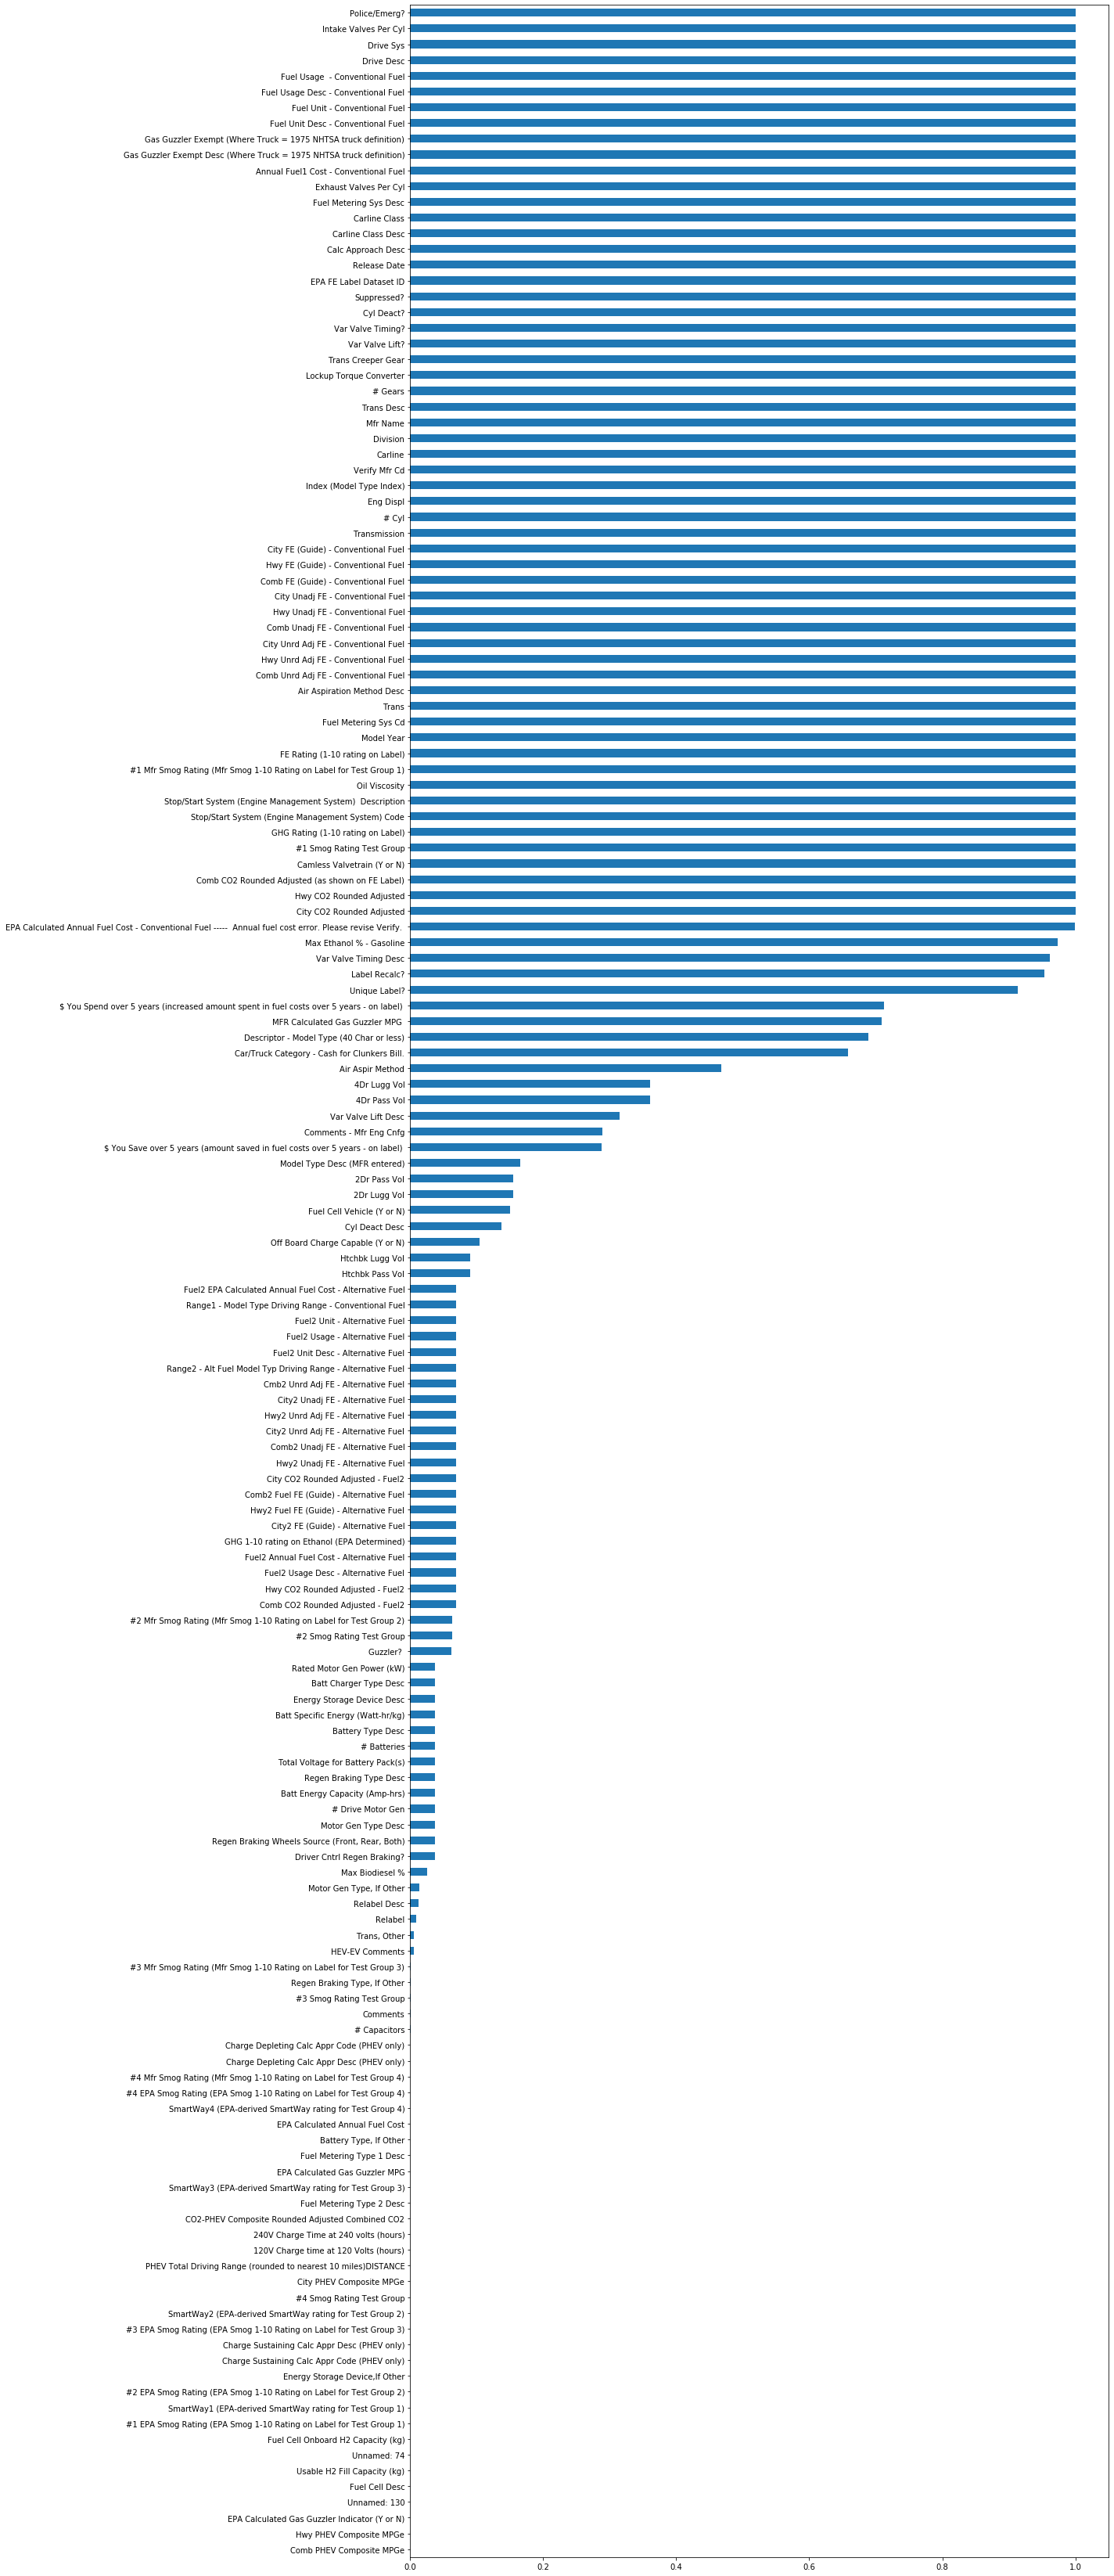

In [8]:
# Bar chart to show percentage of non-missing values
# in a binary setting, mean gives you proportion
df.notnull().mean().sort_values().plot.barh(figsize=(16, 60))

In [9]:
# Which columns have density > 80%
dense_columns = df.columns[df.notnull().mean() > .8]
dense_columns[dense_columns.argsort()]

Index(['# Cyl', '# Gears',
       '#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1)',
       '#1 Smog Rating Test Group', 'Air Aspiration Method Desc',
       'Annual Fuel1 Cost - Conventional Fuel', 'Calc Approach Desc',
       'Camless Valvetrain (Y or N)', 'Carline', 'Carline Class',
       'Carline Class Desc', 'City CO2 Rounded Adjusted',
       'City FE (Guide) - Conventional Fuel',
       'City Unadj FE - Conventional Fuel',
       'City Unrd Adj FE - Conventional Fuel',
       'Comb CO2 Rounded Adjusted (as shown on FE Label)',
       'Comb FE (Guide) - Conventional Fuel',
       'Comb Unadj FE - Conventional Fuel',
       'Comb Unrd Adj FE - Conventional Fuel', 'Cyl Deact?', 'Division',
       'Drive Desc', 'Drive Sys',
       'EPA Calculated Annual Fuel Cost - Conventional Fuel -----  Annual fuel cost error. Please revise Verify. ',
       'EPA FE Label Dataset ID', 'Eng Displ', 'Exhaust Valves Per Cyl',
       'FE Rating (1-10 rating on Label)', 'Fuel Mete

In [10]:
# only 63 / 162 columns have density > 80%
len(dense_columns)

63

## Rename column headers and take only only revelant columns

- multiple columns in which contain duplicate data
- some columns give away hints to the answer = data leakage
- some columns have only unique one value
- removing some features purely for UI integration

In [11]:
# Create object to rename column names
column_names = {
    # 10 features
    'Model Year' : 'model_year',
    'Mfr Name' : 'mfr_name',
    'Carline' : 'carline',
    'Eng Displ' : 'eng_displ',
    '# Cyl' : 'num_cyl',
    'Air Aspiration Method Desc' : 'air_asp',
    '# Gears' : 'num_gears',
    'Trans' : 'trans',
    'Drive Desc' : 'drive_desc',
    # target
    'Comb Unrd Adj FE - Conventional Fuel' : 'comb_unrd_adj_fe'
      
    # removing to have less features to be used in UI
        #'Carline Class Desc' : 'carline_class_desc',
        #'Annual Fuel1 Cost - Conventional Fuel' : 'ann_fuel_cost',
        #'Camless Valvetrain (Y or N)' : 'camless_vt',
        #'Cyl Deact?' : 'cyl_deact',
        #'Division' : 'division',
        #'Exhaust Valves Per Cyl' : 'ex_valv_per_cyl',
        #'Fuel Metering Sys Cd' : 'fuel_meter_sys_cd',
        #'Fuel Usage  - Conventional Fuel' : 'fuel_usage',
        #'Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)' : 'gas_guz_exempt',
        #'Index (Model Type Index)' : 'model_type_index',
        #'Intake Valves Per Cyl' : 'intake_valv_per_cyl',
        #'Lockup Torque Converter' : 'lockup_torque_convert',
        #'Max Ethanol % - Gasoline' : 'max_ethanol',
        #'Oil Viscosity' : 'oil_viscosity',
        #'Stop/Start System (Engine Management System) Code' : 'stop_start_sys_code',
        #'Trans Creeper Gear' : 'trans_creeper_gear',
        #'Unique Label?' : 'unique_lbl',
        #'Var Valve Lift?' : 'var_valv_lift',
        #'Var Valve Timing?' : 'var_val_time',
        #'Var Valve Timing Desc' : 'var_val_time_desc',
        #'Verify Mfr Cd' : 'verify_mfr_cd'
        #'Transmission' : 'transmission',
    
    # removing due to data leakage:
        #'City CO2 Rounded Adjusted' : 'co2_rd_adj',
        #'City FE (Guide) - Conventional Fuel' : 'city_fe',
        #'City Unadj FE - Conventional Fuel' : 'city_unadj_fe',
        #'City Unrd Adj FE - Conventional Fuel' : 'city_unrd_adj_fe',
        #'Comb CO2 Rounded Adjusted (as shown on FE Label)' : 'comb_co2_rd_adj',
        #'Comb FE (Guide) - Conventional Fuel' : 'comb_fe',
        #'Hwy CO2 Rounded Adjusted' : 'hwy_co2_rd_adj',
        #'Hwy FE (Guide) - Conventional Fuel' : 'hwy_fe',
        #'Hwy Unadj FE - Conventional Fuel' : 'hwy_unadj_fe',
        #'Hwy Unrd Adj FE - Conventional Fuel' : 'hwy_unrd_adj_fe',
        #'Comb Unadj FE - Conventional Fuel' : 'comb_unadj_fe',
        #'FE Rating (1-10 rating on Label)' : 'fe_rating',
        #'EPA Calculated Annual Fuel Cost - Conventional Fuel -----  Annual fuel cost error. Please revise Verify. ' : 'epa_calc_ann_fuel_cst',
        #'EPA FE Label Dataset ID' : 'epa_fe_label_data_id',
        #'GHG Rating (1-10 rating on Label)' : 'ghg_rating',
        #'#1 Smog Rating Test Group' : 'smog_group',
        #'#1 Mfr Smog Rating (Mfr Smog 1-10 Rating on Label for Test Group 1)' : 'smog_rating',
        #'Calc Approach Desc' : 'calc_approach',
        #'Label Recalc?' : 'lbl_recalc',
    
    # removing due to repeat of data:
        #'Trans Desc' : 'trans_desc',
        #'Release Date' : 'release_date',
        #'Stop/Start System (Engine Management System)  Description' : 'stop_start_sys_desc',
        #'Gas Guzzler Exempt Desc (Where Truck = 1975 NHTSA truck definition)' : 'gas_guz_exempt_desc',
        #'Fuel Usage Desc - Conventional Fuel' : 'fuel_usage_desc'
        #'Drive Sys' : 'drive_sys',
        #'Carline Class' : 'carline_class',
        #'Fuel Metering Sys Desc' : 'fuel_meter_sys_desc'  
    
    # all the same value
        #'Police/Emerg?' : 'police_emerg',
        #'Suppressed?' : 'supressed',
        #'Fuel Unit - Conventional Fuel' : 'fuel_unit',
        #'Fuel Unit Desc - Conventional Fuel' : 'fuel_unit_desc',
    
}

In [12]:
# rename column headers
df = df.rename(columns=column_names)
df = df[list(column_names.values())]
df_test = df_test.rename(columns=column_names)
df_test = df_test[list(column_names.values())]

df.sample(5)

,model_year,mfr_name,carline,eng_displ,num_cyl,air_asp,num_gears,trans,drive_desc,comb_unrd_adj_fe
3821,2017,BMW,640i xDrive Convertible,3.0,6,Turbocharged,8,SA,All Wheel Drive,22.3606
2869,2016,Volkswagen Group of,GTI,2.0,4,Turbocharged,6,M,"2-Wheel Drive, Front",28.4070
4148,2017,Ford Motor Company,FUSION FWD,1.5,4,Turbocharged,6,SA,"2-Wheel Drive, Front",27.0930
2138,2015,Ford Motor Company,ESCAPE FWD,1.6,4,Turbocharged,6,SA,"2-Wheel Drive, Front",26.0184
5308,2018,General Motors,CRUZE,1.6,4,Turbocharged,9,A,"2-Wheel Drive, Front",36.8031


In [13]:
df.shape

(6197, 10)

## Find missing values

In [15]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())

False
0


## Make columns same type

In [16]:
# find values of carline in which are int
df[df['carline'].apply(lambda x: not isinstance(x, str))]['carline']
df_test[df_test['carline'].apply(lambda x: not isinstance(x, str))]['carline']

85     500
86     500
134     86
135     86
604    300
605    300
606    300
Name: carline, dtype: object

In [25]:
# check values that are not strings current type
print(len(df[df['carline'].apply(lambda x: not isinstance(x, str))]['carline']))
type(df[df['carline'].apply(lambda x: not isinstance(x, str))]['carline'].iloc[0])

40


int

In [26]:
# change values' types to str
df['carline'] = df['carline'].apply(str)
df_test['carline'] = df_test['carline'].apply(str)
df_test[df_test['carline'].apply(lambda x: not isinstance(x, str))]['carline']

Series([], Name: carline, dtype: object)

## Change categorical NaN into 'unknown' category

In [30]:
# define numeric and categorical columns
columns_all = df.columns
columns_numeric = list(df._get_numeric_data().columns)
columns_cat = list(set(columns_all) - set(columns_numeric))

# create numeric and categorical df
df_cat = df[columns_cat]
df_test_cat = df_test[columns_cat]

# find all columns with NaNs
cat_col_nan = list(df_cat[df_cat.isnull().any(axis='columns')].columns)
cat_test_col_nan = list(df_test_cat[df_test_cat.isnull().any(axis='columns')].columns)

# fill all NaNs with 'Unknown'
df[cat_col_nan] = df[cat_col_nan].fillna('Unknown')
df_test[cat_test_col_nan] = df_test[cat_test_col_nan].fillna('Unknown')

# check if any NaN values
print(df[columns_cat].isnull().sum().sum())

0


In [31]:
df.head()

,model_year,mfr_name,carline,eng_displ,num_cyl,air_asp,num_gears,trans,drive_desc,comb_unrd_adj_fe
0,2014,aston martin,V8 Vantage,4.7,8,Naturally Aspirated,7,AM,"2-Wheel Drive, Rear",16.0340
1,2014,aston martin,V8 Vantage,4.7,8,Naturally Aspirated,6,M,"2-Wheel Drive, Rear",15.1973
2,2014,aston martin,V8 Vantage S,4.7,8,Naturally Aspirated,7,AM,"2-Wheel Drive, Rear",16.0340
3,2014,aston martin,V8 Vantage S,4.7,8,Naturally Aspirated,6,M,"2-Wheel Drive, Rear",15.1973
4,2014,Audi,R8,4.2,8,Naturally Aspirated,7,AMS,All Wheel Drive,16.5465


In [32]:
df.describe()

,model_year,eng_displ,num_cyl,num_gears,comb_unrd_adj_fe
count,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000
mean,2016.026142,3.184799,5.664999,6.541391,23.083532
std,1.416823,1.358979,1.862465,1.524421,5.735539
min,2014.000000,0.900000,3.000000,1.000000,10.442400
25%,2015.000000,2.000000,4.000000,6.000000,18.970400
50%,2016.000000,3.000000,6.000000,6.000000,22.452800
75%,2017.000000,3.700000,6.000000,8.000000,26.410400
max,2018.000000,8.400000,16.000000,10.000000,57.782400


## Extract clean data

In [33]:
dump(df, 'clean-cars-ui.csv')

['clean-cars-ui.csv']

# Machine Learning

## Create train and test splits

In [34]:
# targets
y_train = df['comb_unrd_adj_fe']
y_test = df_test['comb_unrd_adj_fe']

# remove targets from df and create train/test splits
X_train = df.drop(columns='comb_unrd_adj_fe')
X_test = df_test.drop(columns='comb_unrd_adj_fe')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6197, 9)
(6197,)
(1260, 9)
(1260,)


## Define transforms 

In [35]:
imputer = SimpleImputer(strategy='median', add_indicator=True)
onehot = OneHotEncoder(handle_unknown='ignore')

## Define estimator

In [36]:
rf = RandomForestRegressor()

## Build pipeline

In [38]:
columns = X_train.columns
columns_num = X_train._get_numeric_data().columns
columns_cat = list(set(columns) - set(columns_num))

preprocessing_numeric = Pipeline([('imputer', imputer)])

ct = ColumnTransformer(
    [
        ('preprocessing_numeric', preprocessing_numeric, 
                                  columns_num),
        ('onehot', onehot, columns_cat)
    ]
)

pipeline = Pipeline(steps = [('ct', ct),
                             ('Model', rf)])

## Define hyperparameter search space

In [39]:
# Number of trees in random forest
n_estimators = [100, 250, 500]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, 5)] + [None]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
rf_param_grid = {'Model__n_estimators': n_estimators,
                 'Model__max_features': max_features,
                 'Model__max_depth': max_depth,
                 'Model__min_samples_leaf': min_samples_leaf}

rf_param_grid

{'Model__n_estimators': [100, 250, 500],
 'Model__max_features': ['auto', 'sqrt'],
 'Model__max_depth': [1, 5, 10, 15, 20, None],
 'Model__min_samples_leaf': [1, 2, 4]}

## Define grid

In [40]:
grid = RandomizedSearchCV(pipeline, param_distributions=rf_param_grid, 
                             cv=3, random_state=42, n_jobs=-1, n_iter=10)

## Fit model

In [41]:
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ct',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('preprocessing_numeric',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                              

## Best hyper parameters

In [42]:
grid.best_params_

{'Model__n_estimators': 500,
 'Model__min_samples_leaf': 2,
 'Model__max_features': 'auto',
 'Model__max_depth': None}

## Make prediction

In [43]:
y_test_pred = grid.predict(X_test)

# Metrics

In [44]:
print("MSE: ", mean_squared_error(y_test, y_test_pred))
print("MAE: ", mean_absolute_error(y_test, y_test_pred))
print("R2:  ", r2_score(y_test, y_test_pred))

MSE:  2.505187489053796
MAE:  0.8933481611219176
R2:   0.9284127549936174


### Actual vs predicted

Text(0, 0.5, 'Predicted')

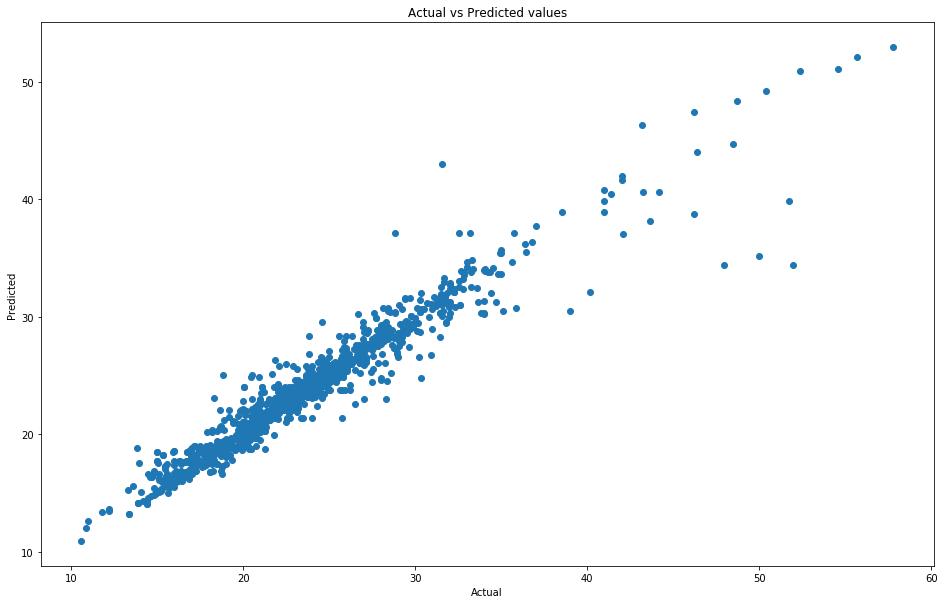

In [45]:
plt.figure(figsize=(16,10))
plt.scatter(x = y_test, y = y_test_pred)
plt.title('Actual vs Predicted values')
plt.xlabel('Actual')
plt.ylabel('Predicted')

### Actual and predicted

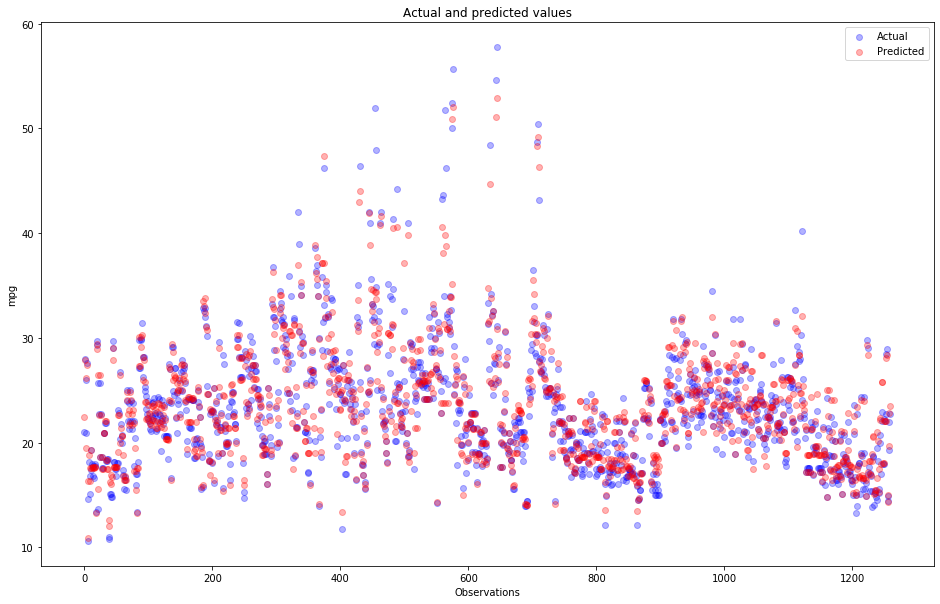

In [46]:
# Plots
_, ax = plt.subplots(figsize=(16,10))
ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_test_pred.size), y=y_test_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

# Extract model

In [47]:
dump(grid, 'model-rf.pkl')

['model-rf.pkl']